In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Library

In [2]:
from skimage.segmentation import flood as flood
from IPython.display import Image
import os
import math
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import skew
from scipy.stats import kurtosis
import scipy.ndimage as ndi
import sklearn.metrics as metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import svm
from skimage.measure   import shannon_entropy
import cv2
from skimage import io
from skimage import color
from skimage.draw import polygon
from skimage.feature import greycomatrix, greycoprops
from sklearn.decomposition import PCA


from skimage.feature import canny
from skimage.filters import sobel
from skimage.transform import hough_line, hough_line_peaks


from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

Segment Image Using ROI

In [3]:
with h5py.File('/content/drive/MyDrive/archive/all_mias_scans.h5', 'r') as scan_h5:
    print("Keys: %s" % scan_h5.keys())
    bg = scan_h5['BG'][:]
    clas = scan_h5['CLASS'][:]
    radius =  scan_h5['RADIUS'][:]
    severity =  scan_h5['SEVERITY'][:]
    scan_lr = scan_h5['scan'][:]
    print('\n|||||||File read successfuly|||||||')

Keys: <KeysViewHDF5 ['BG', 'CLASS', 'RADIUS', 'REFNUM', 'SEVERITY', 'X', 'Y', 'path', 'scan']>

|||||||File read successfuly|||||||


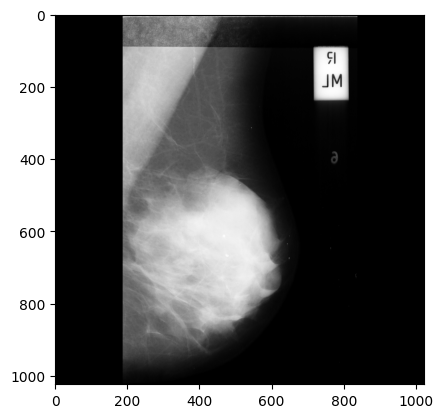

In [4]:
plt.imshow(scan_lr[1], cmap='gray')

In [5]:
scan_lr.shape

(330, 1024, 1024)

In [6]:
def right_orient_mammogram(image):
    left_nonzero = cv2.countNonZero(image[:, 0:int(image.shape[1]/2)])
    right_nonzero = cv2.countNonZero(image[:, int(image.shape[1]/2):])

    if(left_nonzero < right_nonzero):
        image = cv2.flip(image, 1)

    return image

In [7]:
flippedImg = np.zeros((330,1024,1024))

In [8]:
for i in range(330):
    flippedImg[i] = right_orient_mammogram(scan_lr[i])

In [9]:
def forceFlip(img):
    img = cv2.flip(img,1)
    return img

In [10]:
flippedImg[36]=forceFlip(flippedImg[36])
flippedImg[76]=forceFlip(flippedImg[76])
flippedImg[102]=forceFlip(flippedImg[102])
flippedImg[153]=forceFlip(flippedImg[153])
flippedImg[154]=forceFlip(flippedImg[154])
flippedImg[259]=forceFlip(flippedImg[259])
flippedImg[267]=forceFlip(flippedImg[267])
flippedImg[275]=forceFlip(flippedImg[275])
flippedImg[277]=forceFlip(flippedImg[277])
flippedImg[289]=forceFlip(flippedImg[289])
flippedImg[291]=forceFlip(flippedImg[291])
flippedImg[293]=forceFlip(flippedImg[293])
flippedImg[311]=forceFlip(flippedImg[311])
flippedImg[329]=forceFlip(flippedImg[329])

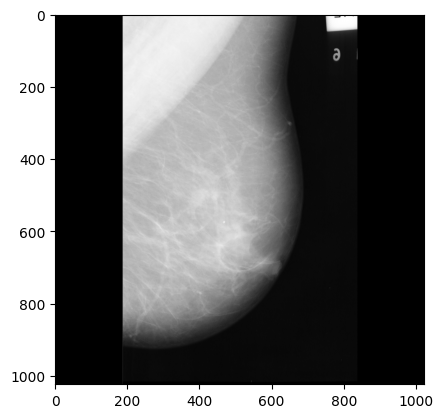

In [11]:
plt.imshow(flippedImg[275], cmap='gray')

In [12]:
def cropLeft(img):
    mini = 0
    pix = 0
    for i in range(1024):
        if img[10][i]>10:
            mini = i
            break
    newimg=np.ones((1024,800))*pix
    diff = 1024-mini
    if diff<800:
        newimg[:,:diff] = img[:,mini:]
    elif diff>800:
        newimg = img[:,mini:(mini+800)]
    elif diff==800:
        newimg = img[:,mini:]
    return newimg

In [13]:
leftCropped = np.zeros((330,1024,800))
for i in range(330):
#     img = right_orient_mammogram(scan_lr[i])
#     print(i)
    imgforcropleft = flippedImg[i]
    leftCropped[i] = cropLeft(imgforcropleft)

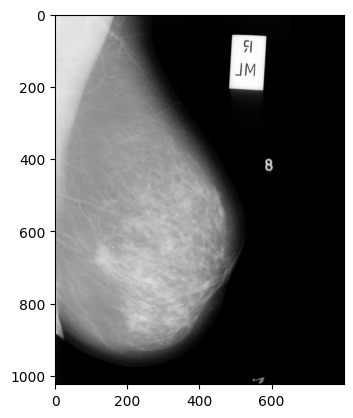

In [14]:
plt.imshow(leftCropped[58],cmap='gray')

In [15]:
!pip install Pillow matplotlib


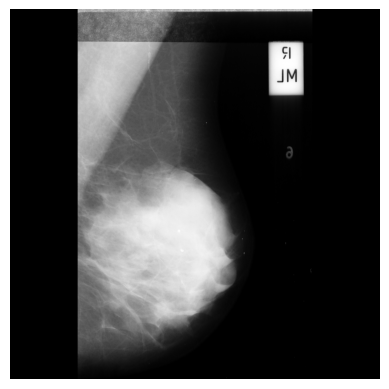

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

# Replace 'path/to/image.pgm' with the actual path to your .pgm image file
image_path = '/content/drive/MyDrive/archive/all-mias/mdb002.pgm'

# Read the .pgm image
image = Image.open(image_path)

# Display the image
plt.imshow(image, cmap='gray')
plt.axis('off')  # Turn off axis ticks and labels
plt.show()


In [17]:
def removeArt(img):
    thresh = 30
    minPix = 40
    newim = np.zeros((1024,800))
    newim = img.copy()
    for i in range(1024):
        start = 0
        for k in range(800):
            if img[100][k] != 0:
                start = k
                break
        for j in range(start , 800-minPix):
            ar = newim[i][j:j+minPix]
            if (all(x < thresh for x in ar)):
                newim[i][j:] = 0
                break
    return newim

In [18]:
artImg = np.zeros((330,1024,800))
for i in range(330):
    artImg[i]  = removeArt(leftCropped[i])

In [19]:
def cropTop(img):
    newim = np.zeros((1024,800))
    newim[:1023,:]=img[1:,:]
    return newim

In [20]:
topCropped = np.zeros((330,1024,800))
for i in range(330):
    topCropped[i]  = cropTop(artImg[i])

In [21]:
new1 = np.zeros((1024,800))
new1[:934,:] = topCropped[1][90:,:]
topCropped[1] = new1

new1 = np.zeros((1024,800))
new1[:1002,:] = topCropped[10][22:,:]
topCropped[10] = new1

new1 = np.zeros((1024,800))
new1[:1009,:] = topCropped[308][15:,:]
topCropped[308] = new1

### Image enhancement

In [22]:
def clahe(img, clip=2.0, tile=(8, 8)):
    img = cv2.normalize(
        img,
        None,
        alpha=0,
        beta=255,
        norm_type=cv2.NORM_MINMAX,
        dtype=cv2.CV_32F,
    )
    img_uint8 = img.astype("uint8")

    clahe_create = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    clahe_img = clahe_create.apply(img_uint8)

    return clahe_img


In [23]:
enhancedImg = np.zeros((330,1024,800))

In [24]:
for i in range(330):
    enhancedImg[i] = clahe(topCropped[i])

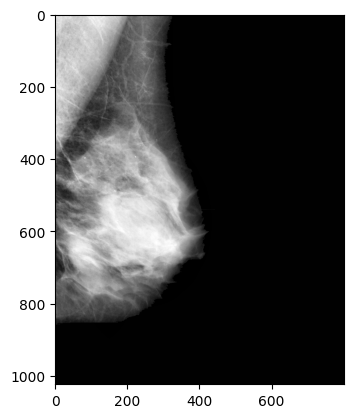

In [25]:
plt.imshow(enhancedImg[0], cmap='gray')

In [26]:
del flippedImg
del leftCropped
del artImg
del topCropped

### Cropping ROI

In [27]:
!pip install Pillow


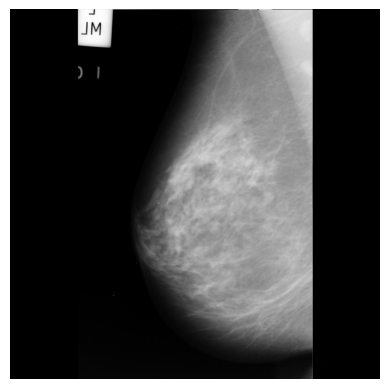

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = '/content/drive/MyDrive/archive/all-mias/mdb007.pgm'

image = Image.open(image_path)

image_array = np.array(image)
plt.imshow(image_array, cmap='gray')
plt.axis('off')  # Turn off axis ticks and labels
plt.show()



In [29]:
def cropRoi(img): # making triangle
    end = -1
    for i in range(800):
        if img[10][i]<10:
            end =i
            break
    myROI = [(0,800),(0,1023),(800,1023),(800,0),(end,0)]
    img = cv2.fillPoly(img, [np.array(myROI)], 0)
    return img

In [30]:
!pip install opencv-python


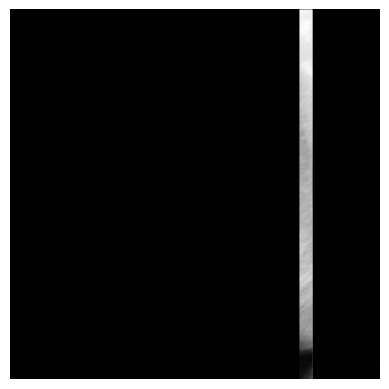

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def cropRoi(img_path): # making triangle
    # Load .pgm image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    end = -1
    for i in range(800):
        if img[150][i] < 150:
            end = i
            break

    myROI = [(0, 800), (0, 1023), (800, 1023), (800, 0), (end, 0)]
    cv2.fillPoly(img, [np.array(myROI)], 0)

    # Save the cropped image as a new .pgm file
    output_path = '/content/drive/MyDrive/archive/all-mias/ROIimage.pgm'  # Replace this with your desired output path
    cv2.imwrite(output_path, img)

    return img

# Call the function and provide the path to your .pgm image
input_image_path = '/content/drive/MyDrive/archive/all-mias/mdb007.pgm'  # Replace this with the path to your .pgm file
output_image = cropRoi(input_image_path)

# Display the output image using matplotlib
plt.imshow(output_image, cmap='gray')
plt.axis('off')  # Turn off axis ticks and labels
plt.show()


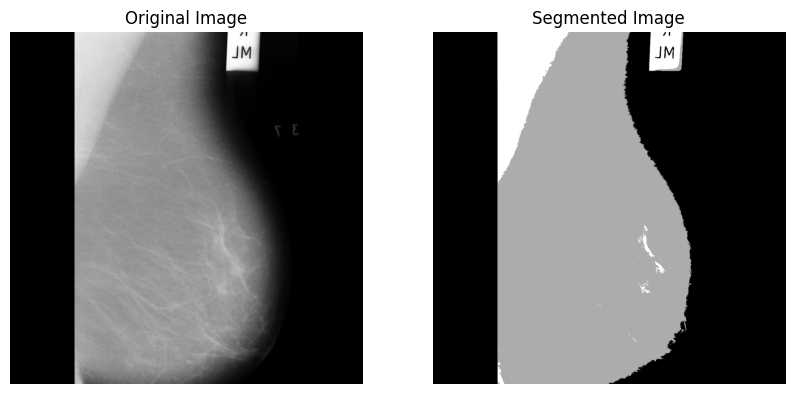

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def newClust(knimage):
    vectorized = knimage.reshape((-1, 1))
    pixel_values = np.float32(vectorized)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    k = 3
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    labels = labels.flatten()

    segmented_image = centers[labels].reshape(knimage.shape)

    return segmented_image

knimage_path = '/content/drive/MyDrive/archive/all-mias/mdb006.pgm'
knimage = cv2.imread(knimage_path, cv2.IMREAD_GRAYSCALE)

segmented_image = newClust(knimage)

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(knimage, cmap='gray')
plt.axis('off')
plt.title('Original Image')

# Segmented image
plt.subplot(1, 2, 2)
plt.imshow(segmented_image, cmap='gray')
plt.axis('off')
plt.title('Segmented Image')

plt.show()


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cvimg = cv2.imread('/content/drive/MyDrive/archive/all-mias/mdb021.pgm', cv2.IMREAD_GRAYSCALE)

def findSeed(img):
    pix = 30
    seed = (10, 30)

    maxi = 0
    for i in range(800):
        for j in range(800):
            if img[i][j] > maxi:
                if (all(x > maxi for x in img[i, j:j+pix])) and (all(y > maxi for y in img[i:i+pix, j])):
                    maxi = img[i][j]
                    seed = (i, j)

    return seed

seed = findSeed(cvimg)
floodimg = flood(cvimg, seed)


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def checkWidth(mimg):
    img = mimg.copy()
    steepDist = 0
    steepLoc = 0
    steepThresh = 30

    for i in range(800):
        for j in range(799, 0, -1):
            localdist = 0
            if img[i][j] == True:
                localdist = j
                if steepDist == 0:
                    steepDist = localdist
                else:
                    if localdist - steepDist > steepThresh:
                        img[steepLoc:, :] = 0
                        return img
                    if localdist < steepDist:
                        steepDist = localdist
                        steepLoc = i
                localdist = 0
                break
    return img


In [35]:
def findDiff(img1,img2):
    for i in range(1024):
        for j in range(800):
            if img1[i][j] >0:
                img2[i][j]=0
    return img2

In [36]:
def newRemove(mimg):
    img=mimg.copy()
    crpimg= cropRoi(img)
    fimg = np.float32(crpimg)
    gimg = cv2.cvtColor(fimg,cv2.COLOR_GRAY2RGB)
    clustimg = newClust(gimg)
    cvimg= cv2.cvtColor(clustimg, cv2.COLOR_BGR2GRAY)
    seed = findSeed(cvimg)
    floodimg  = flood(cvimg, seed)
    widthImg = checkWidth(floodimg)
    cpimg = mimg.copy()
    result = findDiff(widthImg,cpimg)
    return result

In [37]:
newSliced= np.zeros((330,1024,800))

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import cv2
import numpy as np

def cropRoi(img):
    end = -1
    for i in range(800):
        if img[10][i] < 10:
            end = i
            break

    myROI = [(0, 800), (0, 1023), (800, 1023), (800, 0), (end, 0)]
    img = cv2.fillPoly(img, [np.array(myROI)], 0)
    return img.astype(np.uint8)

newSliced = np.zeros((330, 1024, 800))

for i in range(330):
    print(i)
    newSliced[i] = newRemove(enhancedImg[i])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

0


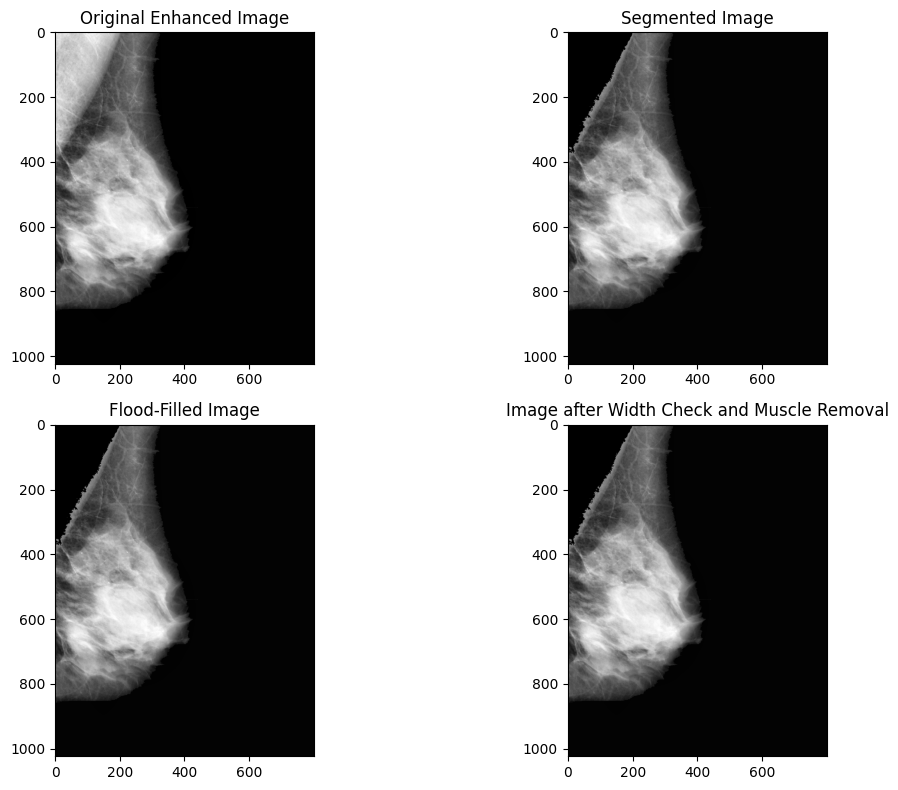

1


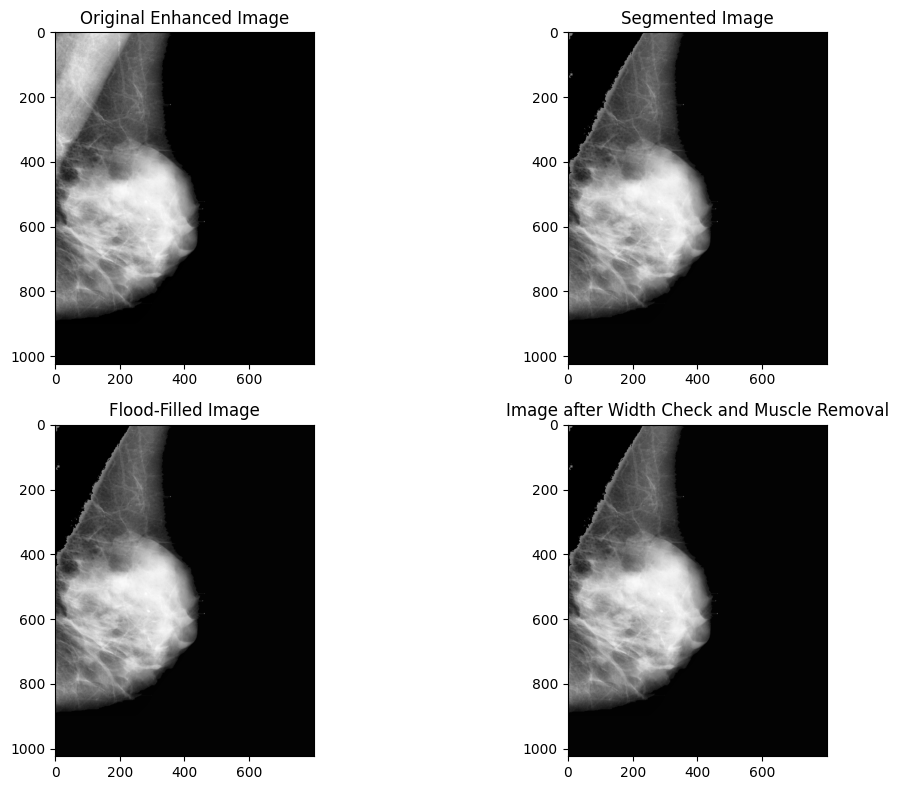

In [39]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def flood_fill(img, seed, fill_value):
    h, w = img.shape
    stack = [(seed[0], seed[1])]

    while stack:
        x, y = stack.pop()
        if 0 <= x < h and 0 <= y < w and img[x, y] == 255:
            img[x, y] = fill_value
            stack.extend([(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1)])

    return img

for i in range(2):
    print(i)
    newSliced[i] = newRemove(enhancedImg[i])

    # Assuming widthImg is returned from the newRemove function, use it here
    widthImg = checkWidth(newSliced[i])

    # Assuming seed point is returned from the findSeed function, use it here
    seed = findSeed(widthImg)

    floodimg = flood_fill(widthImg.copy(), seed, fill_value=0)

    # Create a new figure for each iteration
    plt.figure(figsize=(12, 8))

    # Display the original enhanced image
    plt.subplot(2, 2, 1)
    plt.imshow(enhancedImg[i], cmap='gray')
    plt.title('Original Enhanced Image')

    # Display the segmented image
    plt.subplot(2, 2, 2)
    plt.imshow(newSliced[i], cmap='gray')
    plt.title('Segmented Image')

    # Display the flood-filled image
    plt.subplot(2, 2, 3)
    plt.imshow(floodimg, cmap='gray')
    plt.title('Flood-Filled Image')

    plt.subplot(2, 2, 4)
    plt.imshow(widthImg, cmap='gray')
    plt.title('Image after Width Check and Muscle Removal')

    # Adjust the spacing between subplots to avoid overlap
    plt.tight_layout()

    # Show the figure for this iteration
    plt.show()


For Smooth Image

In [40]:
def checkWidthManual(mimg,steep):
    img =mimg.copy()
    steepDist = 0
    steepLoc=0
    steepThresh=steep
    for i in range(800):
        for j in range(799,0,-1):
            localdist = 0
            if img[i][j]==True:
                localdist = j
                if steepDist ==0:
                    steepDist=localdist
                else:

                    if localdist-steepDist>steepThresh:
                        img[steepLoc:,:] = 0
                        return img
                    if localdist<steepDist:
                        steepDist=localdist
                        steepLoc=i
                localdist=0
                break

    return img

In [41]:
def newRemoveManual(mimg,steep):
    img=mimg.copy()
    crpimg= cropRoi(img)
    fimg = np.float32(crpimg)
    gimg = cv2.cvtColor(fimg,cv2.COLOR_GRAY2RGB)
    clustimg = newClust(gimg)
    cvimg= cv2.cvtColor(clustimg, cv2.COLOR_BGR2GRAY)
    seed = findSeed(cvimg)
    floodimg  = flood(cvimg, seed)
    widthImg = checkWidthManual(floodimg,steep)
    cpimg = mimg.copy()
    result = findDiff(widthImg,cpimg)
    return result

In [42]:
newSliced[34] = newRemoveManual(enhancedImg[34],80)
newSliced[94] = newRemoveManual(enhancedImg[94],50)
newSliced[116] = newRemoveManual(enhancedImg[116],80)
newSliced[138] = newRemoveManual(enhancedImg[138],0)
newSliced[163] = newRemoveManual(enhancedImg[163],95)
newSliced[171] = newRemoveManual(enhancedImg[171],40)
newSliced[222] = newRemoveManual(enhancedImg[222],45)
newSliced[296] = newRemoveManual(enhancedImg[296],220)
newSliced[312] = newRemoveManual(enhancedImg[312],210)
newSliced[315] = newRemoveManual(enhancedImg[315],100)
newSliced[322] = newRemoveManual(enhancedImg[322],200)

In [43]:
def findDiff2(img1,img2):
    img3 =img2.copy()
    for i in range(1024):
        for j in range(800):
            if img1[i][j] ==0:
                img3[i][j]=0
#                 img2 =0
#     plt.imshow(img2)
    return img3

In [44]:
def smoothImg(im):
    ite =15
    ke =3
    image = newSliced[im]
    image = image.astype("uint8")
    blur = cv2.GaussianBlur(image, (3,3), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # Filter using contour area and remove small noise
    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        area = cv2.contourArea(c)
        if area < 1:
            cv2.drawContours(thresh, [c], -1, (0,0,0), -1)
    # Morph close and invert image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (ke,ke))
    close = 255 - cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=ite)
    result = findDiff2(close,enhancedImg[im])
    plt.imshow(result)
    return result

In [45]:
smoothedImg = np.zeros((330,1024,800))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


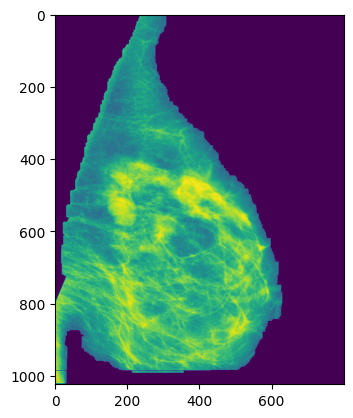

In [47]:
for i in range(20):
    print(i)
    smoothedImg[i]= smoothImg(i)

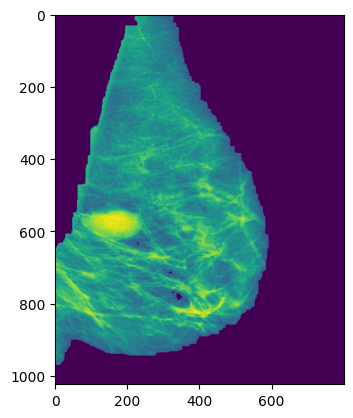

In [48]:
plt.imshow(smoothImg(25))

In [49]:
with h5py.File('/content/drive/MyDrive/archive/slicedImgNEW1.h5/slicedImgNEW1.h5', 'r') as scan_H5:
    print("Keys: %s" % scan_H5.keys())
    severity =  scan_H5['severity'][:]
    scanH5 = scan_H5['img'][:]
    print('\n|||||||File read successfuly|||||||')

Keys: <KeysViewHDF5 ['img', 'severity']>

|||||||File read successfuly|||||||


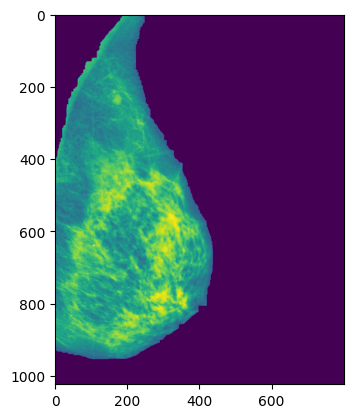

In [50]:
plt.imshow(scanH5[100])